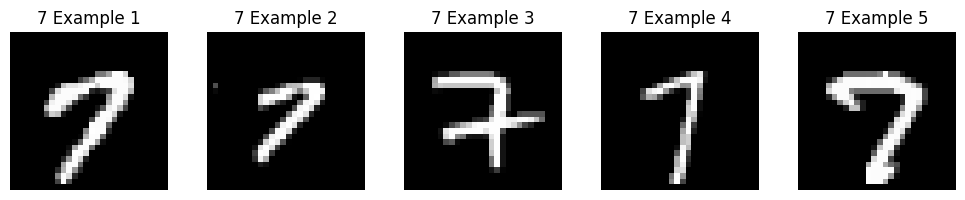

Epoch [1/10] - Train Loss: 0.3478, Train Acc: 0.9051 - Test Loss: 0.1950, Test Acc: 0.9433
Epoch [2/10] - Train Loss: 0.1578, Train Acc: 0.9539 - Test Loss: 0.1244, Test Acc: 0.9644
Epoch [3/10] - Train Loss: 0.1096, Train Acc: 0.9681 - Test Loss: 0.1044, Test Acc: 0.9680
Epoch [4/10] - Train Loss: 0.0831, Train Acc: 0.9754 - Test Loss: 0.0917, Test Acc: 0.9722
Epoch [5/10] - Train Loss: 0.0664, Train Acc: 0.9803 - Test Loss: 0.0813, Test Acc: 0.9763
Epoch [6/10] - Train Loss: 0.0530, Train Acc: 0.9836 - Test Loss: 0.0887, Test Acc: 0.9721
Epoch [7/10] - Train Loss: 0.0436, Train Acc: 0.9870 - Test Loss: 0.0773, Test Acc: 0.9758
Epoch [8/10] - Train Loss: 0.0363, Train Acc: 0.9892 - Test Loss: 0.0777, Test Acc: 0.9751
Epoch [9/10] - Train Loss: 0.0290, Train Acc: 0.9917 - Test Loss: 0.0703, Test Acc: 0.9775
Epoch [10/10] - Train Loss: 0.0246, Train Acc: 0.9928 - Test Loss: 0.0732, Test Acc: 0.9787


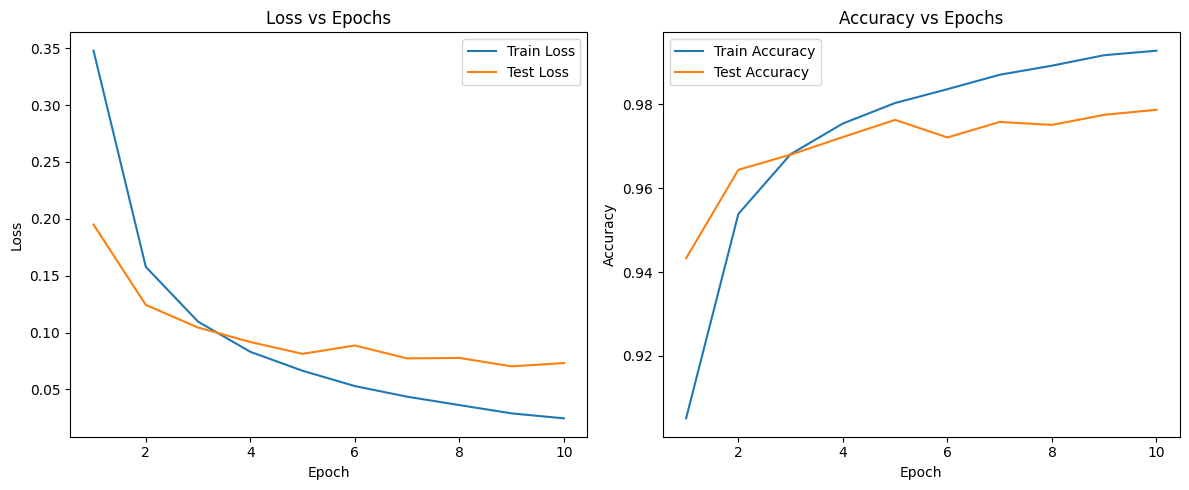

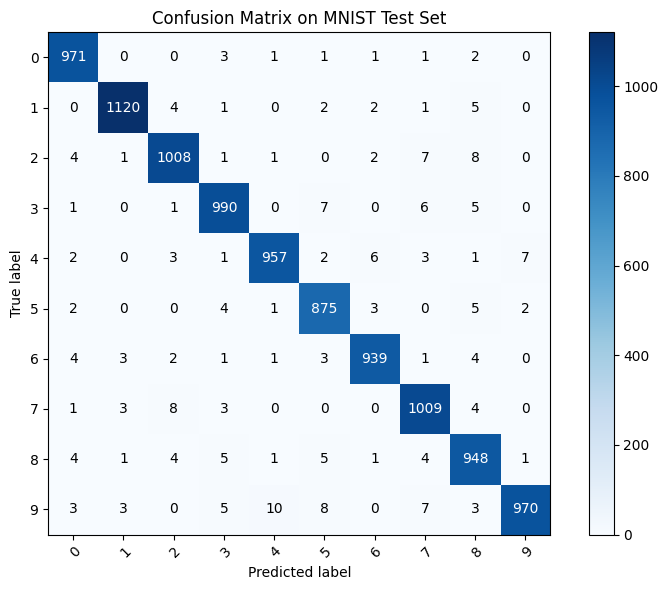

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter out digit '7' and plot first 5 examples
sevens = [(img, label) for img, label in mnist_dataset if label == 7]

plt.figure(figsize=(10, 2))
for i in range(5):
    img, _ = sevens[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'7 Example {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Load train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# To store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluate on test data
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / total
    test_acc = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}] - "
        f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}"
    )

# Plot losses and accuracies
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Collect all predictions and true labels on test set for confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = [str(i) for i in range(10)]

# Plot confusion matrix using matplotlib only
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion Matrix on MNIST Test Set",
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            format(cm[i, j], "d"),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
        )

fig.tight_layout()
plt.show()
